In [1]:
import numpy as np
from nilearn import image

# Load power template coords
powerfile = '/home/anton/Documents/Tulane/Hackathon/power264/power264MNI.nii.gz'

powerimg = image.load_img(powerfile)
datpower = image.get_data(powerimg)

print(datpower.shape)

(91, 109, 91)


In [2]:
# Sort power coordinates

pcoords = []
proinums = []

for roi in range(264):
    x,y,z = np.where(datpower == roi+1)
    pcoords.append(np.stack([x,y,z,np.ones(x.shape[0])]).T)
    proinums.append(roi*np.ones(x.shape[0]))
    
pcoords = np.concatenate(pcoords).T
proinums = np.concatenate(proinums)

print(pcoords.shape)
print(proinums.shape)

(4, 21384)
(21384,)


In [12]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

print('Done')

Done


In [24]:
# Get HCP images
# I think these are already bandpass filtered
# There is also a REST2 directory

from scipy.interpolate import interpn
from pathlib import Path
import re

timeseries = {}
fcs = {}

count = 0
a,b = np.triu_indices(264,1)

fmridir = '/run/media/anton/Samsung_T5/HCP_YoungAdult/REST'

for sub in Path(fmridir).iterdir():
    if sub.is_dir():
        continue
    
    mtch = re.match('^3mm_(.*)_REST.*\\.nii\\.gz$', sub.name)
    
    if not mtch:
        continue

    subid = mtch.group(1)

    print(f'Processing subject {subid}... ', end='')
        
    img = image.load_img(f'{fmridir}/{sub.name}')
    datimg = image.get_data(img)

    coords = np.linalg.inv(img.affine)@powerimg.affine@pcoords
    points = [np.arange(s) for s in img.shape[:-1]]
    
    nt = datimg.shape[-1]
    ts = np.zeros((264,nt))
    res = np.zeros((nt,coords.shape[-1]))

    try:
        for tp in range(nt):
            res[tp] = interpn(points, datimg[:,:,:,tp], coords[:-1].T, bounds_error=False)
    except:
        print(' fail')
        continue

    for roi in range(264):
        ts[roi] = np.mean(res[:,proinums == roi], axis=1)

    timeseries[subid] = ts[ours2orig]
    fcs[subid] = np.corrcoef(timeseries[subid])[a,b]
    
    print(' done')
    
    count += 1
    if count % 10 == 0:
        print(f'Done {count}')

print('All done')

Processing subject 100307...  done
 donessing subject 101006... 
 donessing subject 101309... 
 donessing subject 101915... 
 donessing subject 102311... 
 donessing subject 102513... 
 donessing subject 103414... 
 donessing subject 103818... 
 donessing subject 104012... 
 donessing subject 104416... 
Done 10
 donessing subject 105014... 
 donessing subject 105115... 
 donessing subject 105216... 
 donessing subject 105620... 
 donessing subject 105923... 
 donessing subject 106016... 
 donessing subject 106319... 
 donessing subject 106521... 
 donessing subject 107018... 
 donessing subject 107321... 
Done 20
 donessing subject 107422... 
 donessing subject 108222... 
 donessing subject 108323... 
 donessing subject 108525... 
 donessing subject 108828... 
 donessing subject 110411... 
 donessing subject 110613... 
 donessing subject 111312... 
 donessing subject 111413... 
 donessing subject 111514... 
Done 30
 donessing subject 111716... 
 donessing subject 112112... 
 donessing 

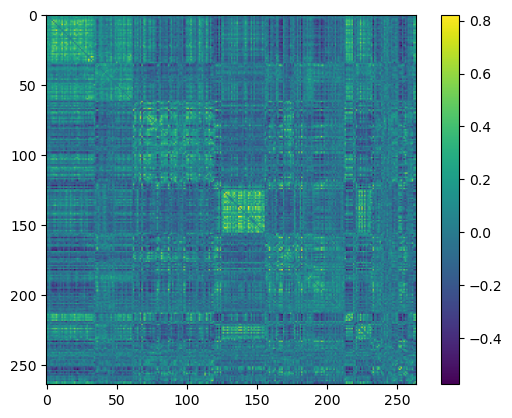

In [28]:
import matplotlib.pyplot as plt

subs = list(timeseries.keys())

plt.imshow(vec2mat(fcs[subs[120]]))
plt.colorbar()
plt.show()

In [29]:
# Dump timeseries and FC

import pickle

hcpdir = '/home/anton/Documents/Yale/HCP'

pickle.dump(timeseries, open(f'{hcpdir}/timeseries_ya.pkl', 'wb'))
pickle.dump(fcs, open(f'{hcpdir}/fcs_ya.pkl', 'wb'))

print('Done')

Done
